In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import os
import cv2

In [4]:
rootdir = r'C:\Users\Wojtek\Documents\Doktorat\Astral\data\Cont_AN_2_2'
file = 'waves.npy'

In [5]:
waves = np.load(os.path.join(rootdir, file)).astype('uint8')

In [11]:
mean_pixels = np.mean(waves, axis=2, dtype=np.float32)
std_pixels = np.std(waves, axis=2, dtype=np.float32)

In [12]:
st_dev = 1.2

In [13]:
waves1 = waves.copy()
threshold1 = np.zeros(waves.shape[:-1])

for i in tqdm(range(waves.shape[0])):
    for j in range(waves.shape[1]):
        slic = waves1[i, j, :]
        threshold1[i, j] = int(mean_pixels[i, j] + st_dev * std_pixels[i, j])
        slic[slic > threshold1[i,j]] = 255
        slic[slic <= threshold1[i,j]] = 0

100%|████████████████████████████████████████████████████████████████████████████████| 608/608 [00:09<00:00, 61.20it/s]


In [14]:
waves2 = waves.copy()



In [15]:
threshold = (mean_pixels + st_dev * std_pixels).astype('uint8')
threshold = np.expand_dims(threshold, axis=-1)

waves2[waves2 > threshold] = 255
waves2[waves2 <= threshold] = 0

In [16]:
np.all(waves1 == waves2)

True

In [17]:
waves1 = waves2.copy()

In [18]:
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

for i in tqdm(range(waves1.shape[2])):
    slic = waves1[:, :, i]
    mask = cv2.morphologyEx(slic, cv2.MORPH_OPEN, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se2)
    waves1[:, :, i] = mask

waves1 = waves1.astype('bool')

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:13<00:00, 91.54it/s]


In [19]:
waves3 = waves2.copy()

In [20]:
from joblib import Parallel, delayed

def perform_opening_closing(slic, se1, se2):
    

    mask = cv2.morphologyEx(slic, cv2.MORPH_OPEN, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se2)
    return mask

In [105]:
filename = 'Cont_AN_2_4.tif'
path = r'C:\Users\Wojtek\Documents\Doktorat\Astral\data'

In [120]:
from PIL import Image
img = Image.open(os.path.join(path, filename))

In [109]:
img.seek(0)

In [111]:
no_frames = img.n_frames

In [177]:
timespace = np.zeros(shape=img.size[::-1]+(no_frames,))

In [178]:
timespace.shape

(608, 960, 1200)

In [182]:
for i in tqdm(range(no_frames)):
    img.seek(i)
    slic = np.array(img)
    timespace[:,:,i] = slic
#timespace = np.swapaxes(timespace, 0, 1)

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:11<00:00, 105.77it/s]


In [11]:
debug_path = r'C:\Users\Wojtek\Documents\Doktorat\Astral\data\Cont_AN_2_2'
waves = np.load(os.path.join(debug_path, "waves_morph.npy"))
from skimage import measure
volume_threshold = 45

In [21]:
import numba

#@numba.jit(parallel=True)
def _indices_label(array, label, offset):
    indices = np.argwhere(array == label)
    indices = [np.concatenate([elem[:-1], [elem[-1] + offset]]) for elem in indices]
    return indices

In [13]:
def get_closest_threshold(myList, myNumber): 
    return min(myList, key=lambda x: abs(x - myNumber))



def get_thresholds(waves, interval=50, axis=2):
    slices = [slic for slic in range(waves.shape[axis]) if not np.any(waves[:, :, slic])]
    length = waves.shape[2]
    to_slice = [i*interval for i in range(int(length/50))]
    out = list(map(lambda x: func(slices, x), to_slice))
    out = [*out, length]
    out = sorted(list(set(out)))
    return out

In [14]:
from numba import prange, njit
import numba


@njit(parallel=True)
def get_cords(labelled, labels):
    a = [0 for item in range(len(labels))]
    for i in prange(len(labels)):
        inds = np.argwhere(labelled == labels[i])
        a.append(inds)
    return a

In [17]:
def get_pixels():
    slices = [slic for slic in range(waves.shape[2]) if not np.any(waves[:, :, slic])]
    length = waves.shape[2]
    to_slice = [i*50 for i in range(int(length/50))]
    def func(myList, myNumber): return min(myList, key=lambda x: abs(x - myNumber))
    out = list(map(lambda x: func(slices, x), to_slice))
    out = [*out, length]
    out = sorted(list(set(out)))

    total = []

    for index in tqdm(range(len(out) - 1)):
        current = waves[:, :, out[index]:out[index + 1]]
        labelled = measure.label(current, connectivity=3).astype('uint16')
        uniq, counts = np.unique(labelled, return_counts=True)
        labels = uniq[1:]
        counts = counts[1:]
        label_counts = list(zip(labels, counts))
        count_filtered = list(filter(lambda x: x[1] > volume_threshold, label_counts))
        if not count_filtered:
            continue
            
        labels, counts = zip(*count_filtered)
        
        object_cords = get_cords(labelled, labels)
        
#         object_cords = Parallel(n_jobs=3, verbose=10)(delayed(_indices_label)
#                                                       (labelled, label, out[index]) for label in labels)
        total.extend(object_cords)


In [18]:
total = get_pixels()

  6%|█████▏                                                                             | 1/16 [00:00<00:14,  1.03it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mCannot unify list(array(int64, 2d, A)) and list(int64) for '$phi16.0.5', defined at <ipython-input-14-b841b1574563> (7)
[1m
File "<ipython-input-14-b841b1574563>", line 7:[0m
[1mdef get_cords(labelled, labels):
[1m    a = [0 for item in range(len(labels))]
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of assignment at <ipython-input-14-b841b1574563> (7)[0m
[1m
File "<ipython-input-14-b841b1574563>", line 7:[0m
[1mdef get_cords(labelled, labels):
[1m    a = [0 for item in range(len(labels))]
[0m    [1m^[0m[0m


In [22]:
from joblib import Parallel, delayed

slices = [slic for slic in range(waves.shape[2]) if not np.any(waves[:, :, slic])]
length = waves.shape[2]

to_slice = [i*50 for i in range(int(length/50))]
def func(myList, myNumber): return min(myList, key=lambda x: abs(x - myNumber))
out = list(map(lambda x: func(slices, x), to_slice))
out = [*out, length]
out = sorted(list(set(out)))

total = []

for index in tqdm(range(len(out) - 1)):
    current = waves[:, :, out[index]:out[index + 1]]
    labelled = measure.label(current, connectivity=3).astype('uint16')
    last_slice = index
    uniq, counts = np.unique(labelled, return_counts=True)
    labels = uniq[1:]
    counts = counts[1:]
    label_counts = list(zip(labels, counts))
    count_filtered = list(filter(lambda x: x[1] > volume_threshold, label_counts))
    if not count_filtered:
        continue
    labels, counts = zip(*count_filtered)
    object_cords = Parallel(n_jobs=5, verbose=10)(delayed(_indices_label)
                                                  (labelled, label, out[index]) for label in labels)
    total.extend(object_cords)


  0%|                                                                                           | 0/16 [00:00<?, ?it/s][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=5)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:    0.5s finished
 12%|██████████▍                                                                        | 2/16 [00:01<00:07,  1.81it/s][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s
[

In [183]:
timespace = timespace.astype('uint8')

In [184]:
timespace_orig = np.load(os.path.join(rootdir, 'timespace.npy'))

In [186]:
np.all(timespace == timespace_orig)

True

In [168]:
timespace.shape

(960, 608, 1200)

In [181]:
timespace_orig.shape

(608, 960, 1200)

In [158]:
np.array(img.seek(0))

array(None, dtype=object)

In [166]:
timespace

array([[[43, 40, 40, ..., 37, 31, 23],
        [31, 37, 42, ..., 32, 32, 25],
        [32, 37, 36, ..., 27, 33, 23],
        ...,
        [22, 26, 27, ..., 15, 10, 22],
        [29, 27, 28, ..., 22, 18, 23],
        [31, 32, 40, ..., 18, 17, 13]],

       [[45, 37, 29, ..., 32, 30, 25],
        [34, 36, 35, ..., 19, 26, 28],
        [30, 29, 40, ..., 32, 23, 35],
        ...,
        [32, 28, 26, ..., 22, 20, 29],
        [31, 33, 37, ..., 31, 24, 29],
        [30, 36, 26, ..., 25, 26, 20]],

       [[32, 26, 30, ..., 32, 25, 24],
        [43, 35, 34, ..., 40, 24, 29],
        [43, 30, 31, ..., 24, 26, 23],
        ...,
        [39, 30, 34, ..., 23, 19, 18],
        [34, 30, 31, ..., 11, 23, 30],
        [37, 31, 44, ..., 24, 25, 31]],

       ...,

       [[30, 28, 27, ..., 35, 27, 25],
        [39, 29, 32, ..., 33, 30, 34],
        [29, 31, 29, ..., 36, 30, 35],
        ...,
        [47, 56, 56, ..., 58, 62, 52],
        [64, 70, 72, ..., 63, 72, 75],
        [59, 62, 69, ..., 78, 68

In [165]:
timespace_orig

array([[[43, 40, 40, ..., 37, 31, 23],
        [45, 37, 29, ..., 32, 30, 25],
        [32, 26, 30, ..., 32, 25, 24],
        ...,
        [30, 28, 27, ..., 35, 27, 25],
        [11, 27, 27, ..., 35, 32, 27],
        [28, 28, 30, ..., 28, 28, 36]],

       [[31, 37, 42, ..., 32, 32, 25],
        [34, 36, 35, ..., 19, 26, 28],
        [43, 35, 34, ..., 40, 24, 29],
        ...,
        [39, 29, 32, ..., 33, 30, 34],
        [27, 31, 16, ..., 18, 33, 27],
        [29, 30, 24, ..., 31, 26, 42]],

       [[32, 37, 36, ..., 27, 33, 23],
        [30, 29, 40, ..., 32, 23, 35],
        [43, 30, 31, ..., 24, 26, 23],
        ...,
        [29, 31, 29, ..., 36, 30, 35],
        [32, 34, 22, ..., 31, 22, 31],
        [21, 28, 26, ..., 28, 25, 33]],

       ...,

       [[22, 26, 27, ..., 15, 10, 22],
        [32, 28, 26, ..., 22, 20, 29],
        [39, 30, 34, ..., 23, 19, 18],
        ...,
        [47, 56, 56, ..., 58, 62, 52],
        [54, 56, 62, ..., 65, 55, 68],
        [61, 50, 53, ..., 76, 70

In [146]:
slic = img.seek(2)

In [147]:
slic

In [141]:
timespace.shape

(608, 960, 1200)

In [142]:
timespace_orig.shape

(608, 960, 1200)

In [143]:
timespace

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [76]:
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))


mask = cv2.morphologyEx(waves3, cv2.MORPH_OPEN, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se2)
#waves3[:, :, i] = mask

#waves3 = waves3.astype('bool')

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\core\src\matrix.cpp:757: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'cv::Mat::locateROI'


In [2]:
path = "D:\Doktorat\Essen\debug_data\waves_norm.npy"

In [3]:
a = [2, 3, 6, 7]

In [63]:
waves_norm = np.load(path)

In [64]:
which = 200

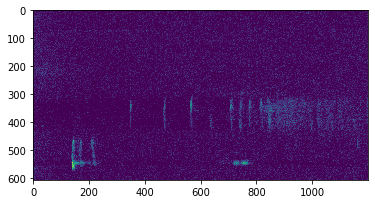

In [65]:
plt.imshow(waves_norm[:,which,:])

In [100]:
example = waves_norm[:,which,:].copy()

In [101]:
example = cv.Canny(example,30,100,apertureSize = 3)

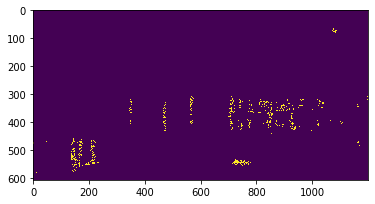

In [109]:
plt.imshow(example)

In [107]:

minLineLength=100
lines = cv.HoughLinesP(image=example,rho=0.1,theta=np.pi/180, threshold=200,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)


In [108]:
a,b,c = lines.shape
for i in range(a):
    cv.line(example, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 3, cv.LINE_AA)
    cv.imwrite('houghlines5.jpg',example)

AttributeError: 'NoneType' object has no attribute 'shape'

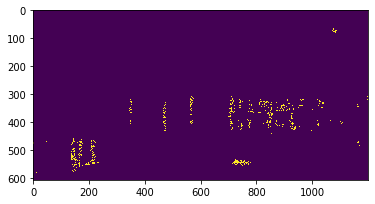

In [105]:
plt.imshow(example)